Corpus Analytics
==============

Now that we've overviewed all the steps involved in preparing text for computational analysis, we can begin the 
work of analysis proper. Whereas the last chapter suggested a few ways we might do this with a single novel, this 
one will build out to a whole collection of texts, or a **corpus**. Computational analysis can help us discover 
many interesting things about a single text, but looking at this text in the context of many others will do much to 
clarify and expand any potential findings we might make. Accordingly, we'll learn how to implement our cleaning 
steps on multiple files and then format them in a way that enables us to make connections between them. We'll then 
generate several metrics about these texts and use them to observe similarities/differences across the corpus.

We'll also leave _Frankenstein_ behind, at least for now. In place of this novel, we will use Andrew Piper's 
[collection of English short stories](https://doi.org/10.6084/m9.figshare.17425571.v1), which gathers together 50 
stories from 1981 to 2006. **UNCLEAR WHETHER WE'LL ULTIMATELY USE THIS ONE---PLUGGING IT IN TO OUTLINE THE 
CHAPTER.**

```{admonition} Learning Objectives
By the end of this workshop, you will be able to:

+ Develop a workflow for cleaning multiple texts and compiling them into a corpus
+ Use a document-term matrix, to represent relationships between texts in a corpus
+ Generate metrics about texts in a corpus, including document length, term frequency, lexical diversity, etc.
+ Explain the difference between raw term metrics and weighted term scoring (specifically, TF-IDF scoring)
+ Cluster texts according to their shared/similar features
```

The Data
-----------

Before we begin cleaning, let's load in a file manifest to get a quick overview of what will be in our corpus. 
We'll also use this manifest to sequentially load each file, clean it, and add it to our corpus.

Number of stories: 50 
Number of authors: 50 
Columns in the manifest: ['NAME' 'TITLE' 'YEAR' 'FILE_NAME']


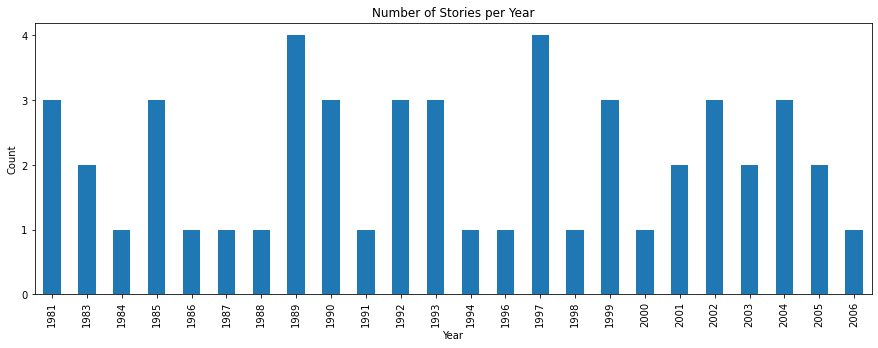

In [1]:
import pandas as pd

indir =  "data/session_two/"
manifest = pd.read_csv(indir + "manifest.csv", index_col = 0)

print(
    "Number of stories:", len(manifest),
    "\nNumber of authors:", manifest['NAME'].nunique(),
    "\nColumns in the manifest:", manifest.columns.values
)
manifest.groupby('YEAR')['TITLE'].count().plot.bar(figsize = (15,5),
                                                   title = "Number of Stories per Year",
                                                   xlabel = "Year",
                                                   ylabel = "Count",
                                                   yticks = range(0,5)
                                                  );

Here are a few story titles, selected at random:

In [2]:
for idx in manifest.sample(5).index:
    print(f"{manifest.loc[idx, 'NAME']}:", manifest.loc[idx, 'TITLE'])

SILBER, Joan: MyShape
DYBEK, Stuart: WeDidn’t
O’BRIEN, Tim: TheThingsTheyCarried
JONES, Thom: ThePugilistatRest
BANKS, Russell: SarahColeATypeofLoveStory


```{tip}
Using a metadata sheet like this is a good habit to develop. Use it as a common reference point for any processes 
you run on your data, and you'll mitigate major headaches stemming from undocumented projects. For more about this, 
see the DataLab's [workshop on project organization and data documentation][].

[workshop on project organization and data documentation]: https://ucdavisdatalab.github.io/workshop_how-to-data-documentation/
```

Text Cleaning
----------------

### Recap

With our manifest loaded, we can review our cleaning steps. For each short story in our corpus, we want to:

1. Resolve casing
2. Remove punctuation, numbers, and any extra formatting
3. Remove stop words

```{margin} Note:
Because lemmatization can be labor-intensive, these texts have already been processed with `nltk`'s lemmatizer.
```

This should feel familiar, though our workflow here will differ slightly from the one in the last chapter because 
we'll be cleaning multiple texts, not only one. All the principles remain the same, we just want to implement our 
cleaning steps in a way that successively works through every text in our data directory without much intervention 
on our part. This is where functions are helpful; we'll define a series of them, with each performing a separate 
step in the cleaning process. We'll also define a main function, `clean()`, which we'll use to control the various 
cleaning steps. That way, we can simply load in a text file and pass it to `clean()` and `clean()` will handle the 
rest.

### Defining our text cleaning functions

`clean()` will call the following five functions:

1. `to_lower()`: returns a lowercase version of all tokens in a text
2. `remove_punctuation()`: removes all punctuation in phases: hyphens, em dashes, and underscores first, then 
everything else
3. `remove_digits()`: removes digits
4. `remove_whitespace()`: removes any extra whitespace
5. `remove_stop_words()`: filters out stop words from the list of tokens; we'll also remove any words that are two 
or less characters long

Let's get coding!

In [3]:
import re

with open("data/voyant_stoplist.txt", 'r') as f:
    stopwords = f.read().split()

def to_lower(doc):
    return doc.lower()

def remove_punctuation(doc):
    doc = re.sub(r"[-]|[—]|[_]", " ", doc)
    doc = re.sub(r"[^\w\s]", "", doc)
    return doc

def remove_digits(doc):
    return re.sub(r"[0-9]", "", doc)

def remove_whitespace(doc):
    doc = re.sub(r"\s+", " ", doc)
    return doc

def remove_stop_words(doc):
    doc = doc.split()
    doc = [token for token in doc if token not in stopwords]
    doc = [token for token in doc if len(token) > 2]
    doc = ' '.join(doc)
    return doc

def clean(doc):
    lowercase = to_lower(doc)
    no_punct = remove_punctuation(lowercase)
    no_digits = remove_digits(no_punct)
    no_whitespace = remove_whitespace(no_digits)
    stopped = remove_stop_words(no_whitespace)
    return stopped

```{admonition} About the above...
These functions are written with **clarity** and **modularity** in mind. The intent here is to demonstrate each 
step of the cleaning process in as discrete a manner as possible. But you might find that some of this code is 
redundant (as an example, ask yourself: which step might be wrapped up inside another function?). Further, we could 
very probably re-factor this code to optimize it, which would be important when working with a large number of 
texts. We won't cover something like that in this session, however. For now, know that these functions are meant to 
act as templates, which you can modify to suit your own needs.
```

### Cleaning our texts

With our functions defined, we can now load each story, roll through all the cleaning steps, and append the cleaned 
story to a list. The result will be our **corpus**, a fifty-item list of strings, where each string contains all 
the tokens in a given story. The _order_ of these entries will be important for work we want to do later on, so we 
need to make sure that each string always has the same position in the larger list of stories. This is where the 
file manifest comes in: _we'll load stories in the order provided by the `FILE_NAME` column of `manifest`_. Doing 
so ensures that the first index (`0`) of our corpus corresponds to the first short story, the second index (`1`) to 
the second, and so on.


Let's write all this out in a `for` loop and do our cleaning.

```{margin} What this loop does:
1. For every row (`idx`) in `manifest`, collect the item in the row's `FILE_NAME` column and append it to `indir`
2. Put the resultant filepath in a `with...open` statement to read in a file
3. Clean the story with `clean()`
4. Append the result to `corpus`
```

In [4]:
corpus = []

for idx in manifest.index:
    filepath = indir + manifest.loc[idx, 'FILE_NAME']
    with open(filepath, 'r') as f:
        story = f.read()
        cleaned_story = clean(story)
        corpus.append(cleaned_story)

As a sanity check, we can run an assertion statement, which checks that `corpus` has as many stories in it as 
`manifest` does...

In [5]:
assert len(corpus) == len(manifest)

...and we can inspect some tokens from a few stories to make sure all is well:

In [6]:
for idx in [4, 17, 39]:
    fragment = corpus[idx].split()
    print(' '.join(fragment[10:20]))

behind card table outside food minutes sun shifts moves chair
barbie away ken practicing future sat sisters room watching barbie
silver clouds floating horizon robins sparrows calling trees son joshuas


Looks great!

The Document-Term Matrix
======================

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
vectorized = count_vectorizer.fit_transform(corpus)

print(
    f"Shape of our document-term matrix: {vectorized.shape},", 
    f"or {vectorized.shape[0]} documents and {vectorized.shape[1]} words"
)

Shape of our document-term matrix: (50, 18603), or 50 documents and 18603 words


`CountVectorizer()` returns a **sparse matrix**, or a matrix comprised mostly of zeros. This matrix has been 
formatted to be highly memory efficient (which is useful when dealing with giant datasets), but it's not 
particularly accessible for data exploration. Since our corpus is relatively small, we'll convert this sparse 
matrix into a `Pandas` dataframe.

In [8]:
dtm = pd.DataFrame(vectorized.toarray())
dtm.iloc[:5,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,9,0


As it stands, this dataframe is hard to understand. But luckily, we've kept track of which row corresponds to which 
story: this is why we used our manifest to control our file order. Further, `CountVectorizer()` has a special 
method, `get_feature_names_out()`, which will generate an array of all the tokens from all the files. The order of 
this array corresponds to the order of our columns. Accordingly, we can assign this array to the column names of 
`dtm` and assign the story titles in `manifest['TITLE']` to its index names, making it much easier to associate 
column values with row values.

In [9]:
dtm.columns = count_vectorizer.get_feature_names_out()
dtm.index = manifest['TITLE']
dtm.iloc[:5,:15]

,aaa,aaaaargh,aaaargh,aachen,aachens,aahed,aback,abandon,abandoned,abandoning,abbey,abbreviated,abby,abbylucyferny,abdomen
TITLE,,,,,,,,,,,,,,,
TheSchool,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tony’sStory,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NineteenFifty-five,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Girl,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Territory,0,0,0,0,0,0,0,0,0,0,0,0,1,9,0


Term Metrics
===========

Raw Metrics
---------------

In [10]:
import numpy as np

manifest = manifest.assign(NUM_TOKENS = dtm.T.apply(sum).values)
manifest = manifest.assign(NUM_TYPES = dtm.T.apply(np.count_nonzero).values)
manifest = manifest.assign(TTR = (manifest['NUM_TYPES'] / manifest['NUM_TOKENS']) * 100)

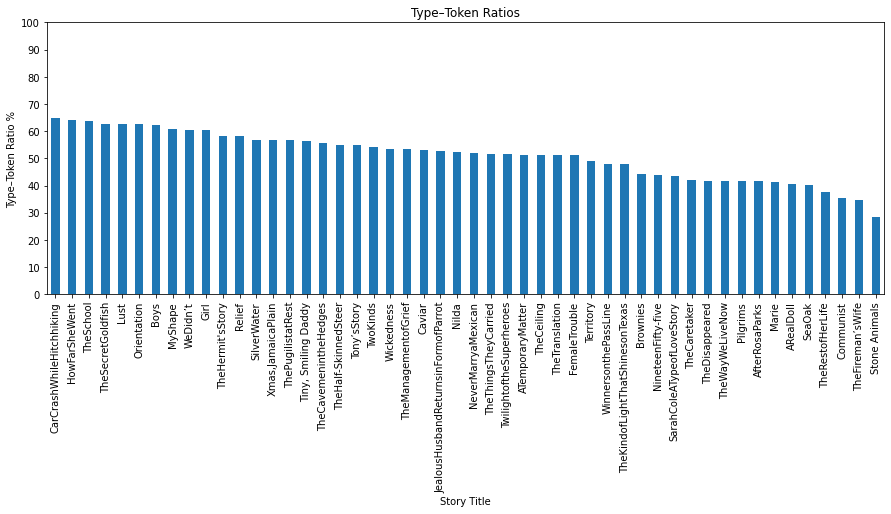

In [11]:
manifest.sort_values('TTR', ascending = False).plot.bar(figsize = (15,5),
                                                        x = 'TITLE', 
                                                        y = 'TTR',
                                                        title = 'Type–Token Ratios',
                                                        legend = None,
                                                        xlabel = 'Story Title',
                                                        ylabel = 'Type–Token Ratio %',
                                                        yticks = range(0, 110, 10)
                                                       );

In [12]:
dtm.idxmax(axis = 1) # use to pivot to tf-idf

TITLE
TheSchool                                  said
Tony’sStory                                leon
NineteenFifty-five                         said
Girl                                       dont
Territory                                  neil
HowFarSheWent                              girl
SarahColeATypeofLoveStory                 sarah
Caviar                                    marie
WinnersonthePassLine                        ray
TheWayWeLiveNow                            said
Communist                                  said
TheManagementofGrief                       says
TheFireman’sWife                           says
Wickedness                                 snow
Lust                                       like
TwoKinds                                 mother
TheDisappeared                             said
ARealDoll                                barbie
TheThingsTheyCarried                    carried
NeverMarryaMexican                         like
CarCrashWhileHitchhiking          

Weighted Metrics
--------------------